In [133]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

# Overview
This project aims to detect and classify different skin care products using machine learning. The model is trained on a dataset containing images of various skin care products, and it can predict the category or type of each product.

In [134]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

## Importing libraries

In [135]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import os

import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Understanding the Data & Data Prerocessing

Skin cancer is not only the most common human malignancy but also a complex medical enigma. The visual subtleties in skin lesions often lead to challenges in accurate and early diagnosis. In a world where precision matters, can artificial intelligence bring a new dimension to this battle? Introducing the HAM10000 dataset ("Human Against Machine with 10,000 training images"), a gold mine for researchers and data scientists, consisting of 10,015 dermatoscopic images. 
This dataset represents a stepping stone towards automation in skin cancer classification, with its seven different classes:

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:

1. Actinic keratoses and intraepithelial carcinoma / Bowen's disease (AKIEC),

2. basal cell carcinoma (BCC),

3. benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, BKL),

4. dermatofibroma (DF),

5. melanoma (MEL),

6. melanocytic nevi (NV)

7. vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, VASC).

In [136]:
path='/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'

In [137]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [138]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [140]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [141]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

## Map Dataset

In [142]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

In [143]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [144]:
print(imageid_path_dict)

{'ISIC_0028933': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028933.jpg', 'ISIC_0028394': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028394.jpg', 'ISIC_0027799': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027799.jpg', 'ISIC_0028100': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028100.jpg', 'ISIC_0027960': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027960.jpg', 'ISIC_0028872': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028872.jpg', 'ISIC_0026412': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0026412.jpg', 'ISIC_0024872': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0024872.jpg', 'ISIC_0026232': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0026232.jpg', 'ISIC_0027031': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027031.jpg', 'ISIC_0026692': '../input/skin-cancer-mnist-ham10

In [145]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

## Handling Missing Values

In [146]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [147]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [148]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

## Exploratory Data Analysis

To begin this exploratory analysis, first use matplotlib to import libraries and define functions for plotting the data.

In [149]:
df['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

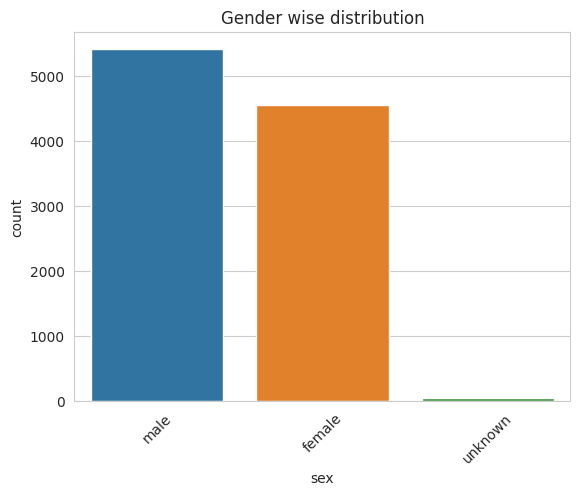

In [150]:
ax = sns.countplot(x = 'sex', data = df)
plt.title('Gender wise distribution')
plt.xticks(rotation=45)
plt.show()

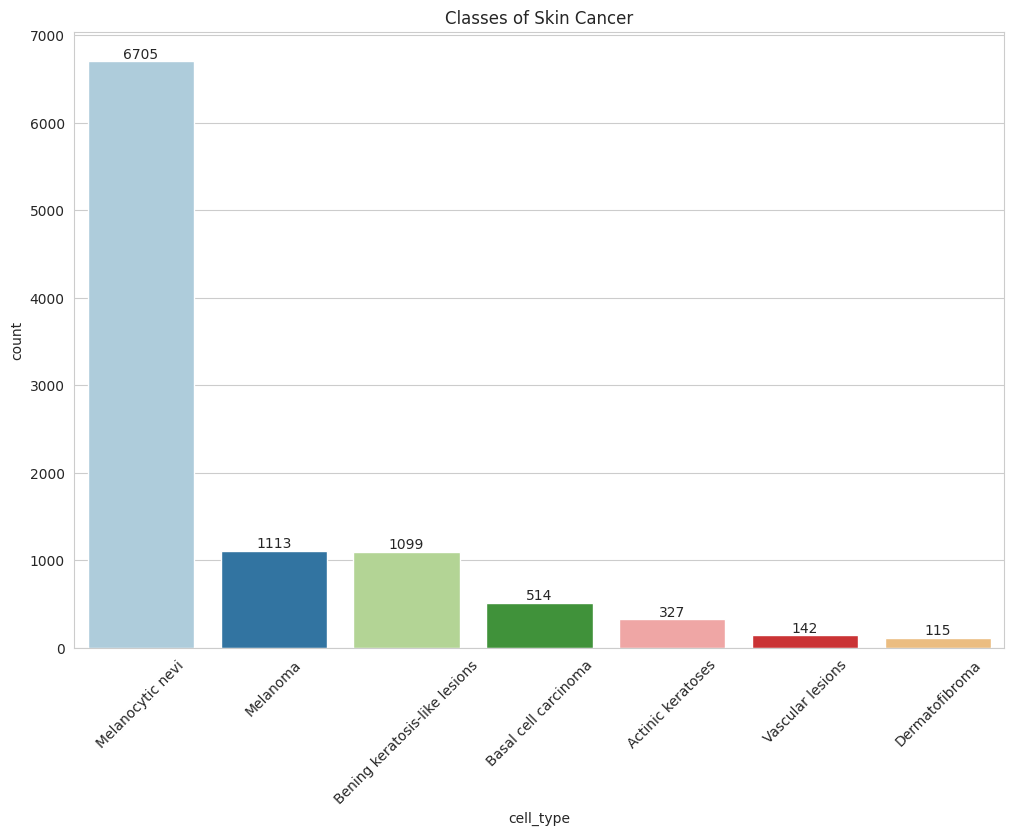

In [151]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Classes of Skin Cancer')
plt.xticks(rotation=45)
plt.show()


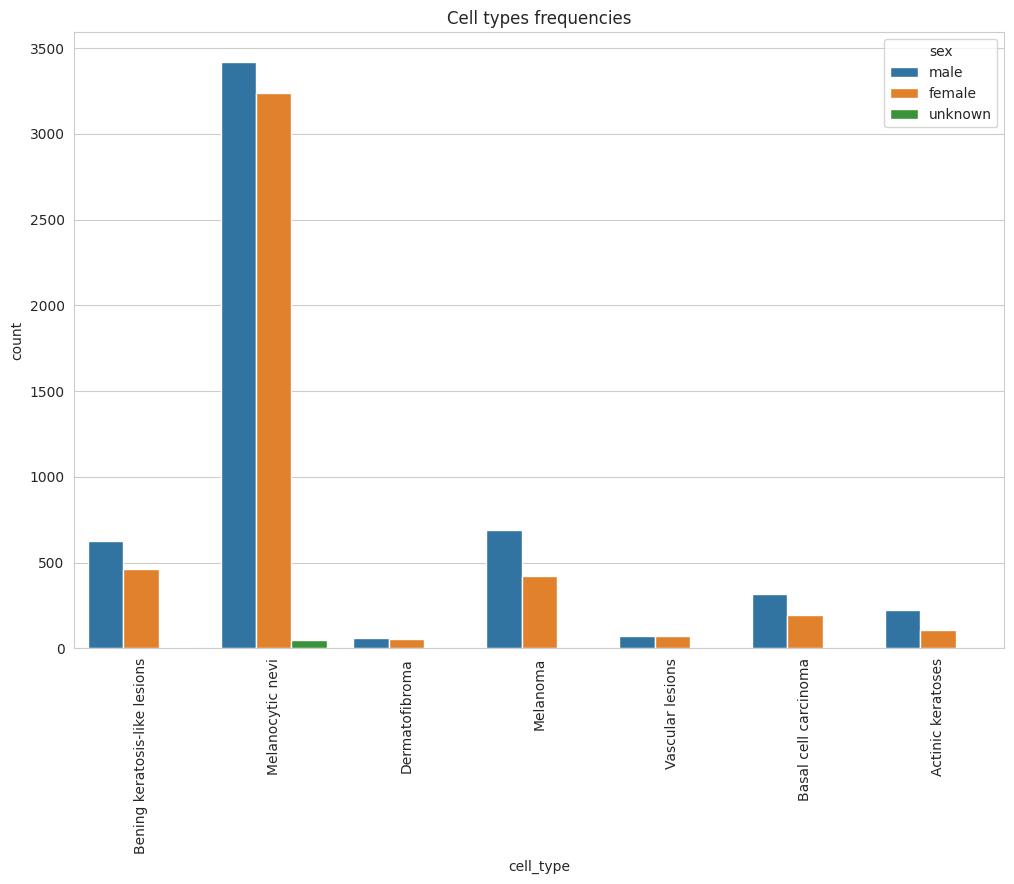

In [152]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type', hue='sex', data = df)
plt.title('Cell types frequencies')
plt.xticks(rotation=90)
plt.show()

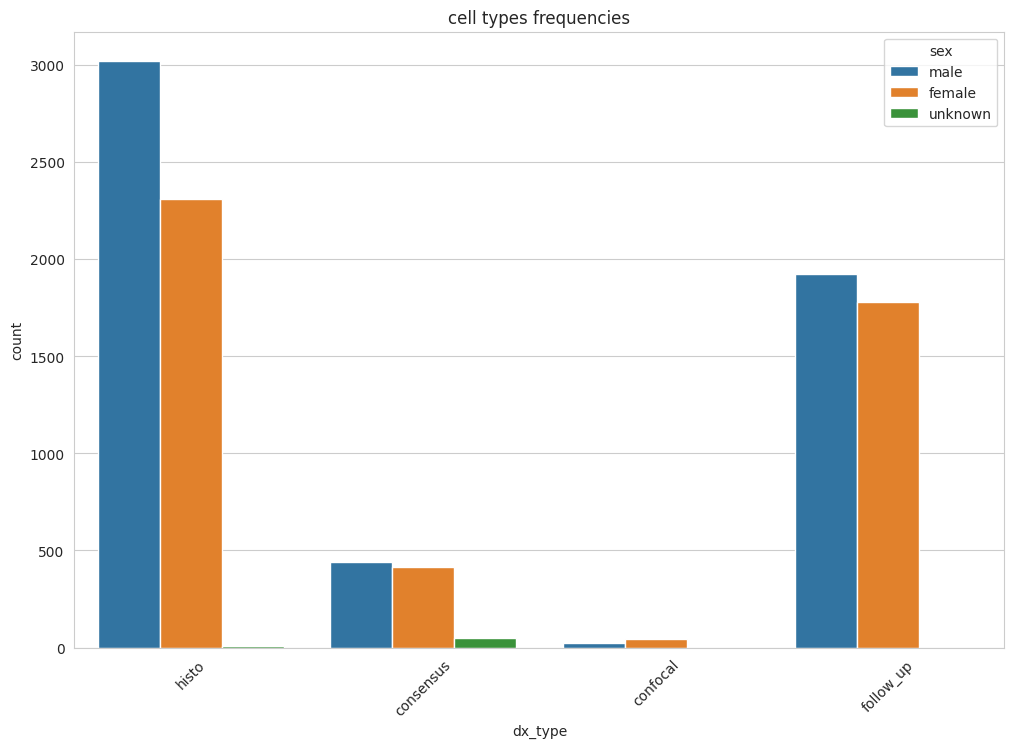

In [153]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type', hue = 'sex', data = df)
plt.title('cell types frequencies')
plt.xticks(rotation=45)
plt.show()

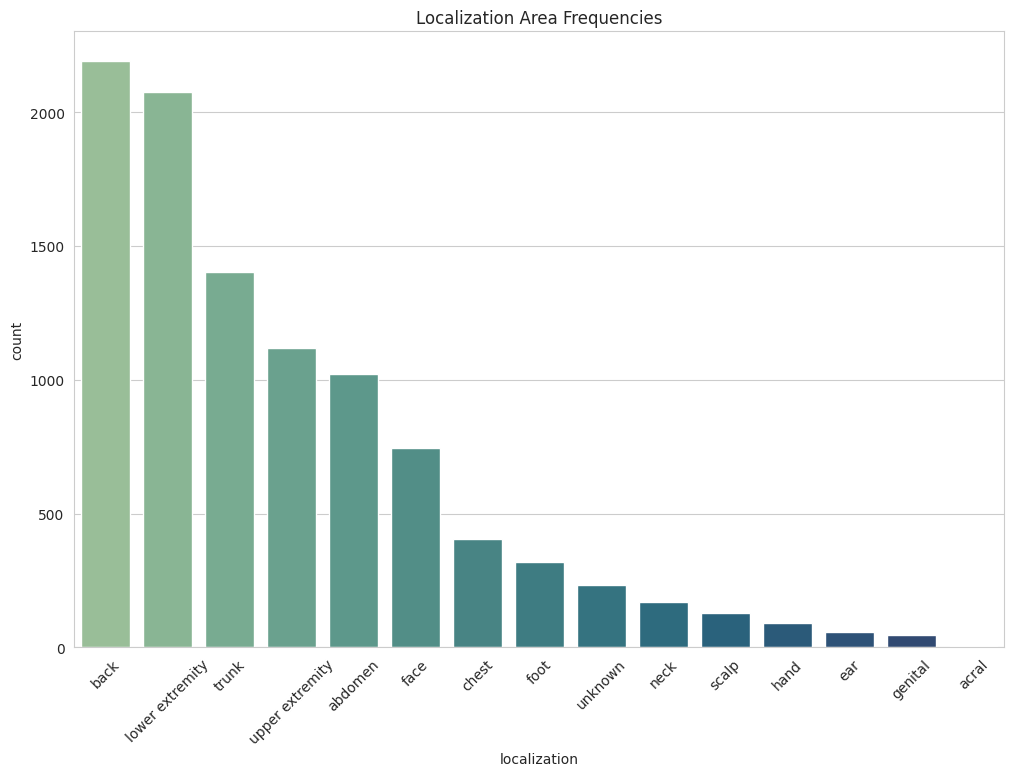

In [154]:
sns.set_style('whitegrid')
fig,axis = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization', data=df, order=df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

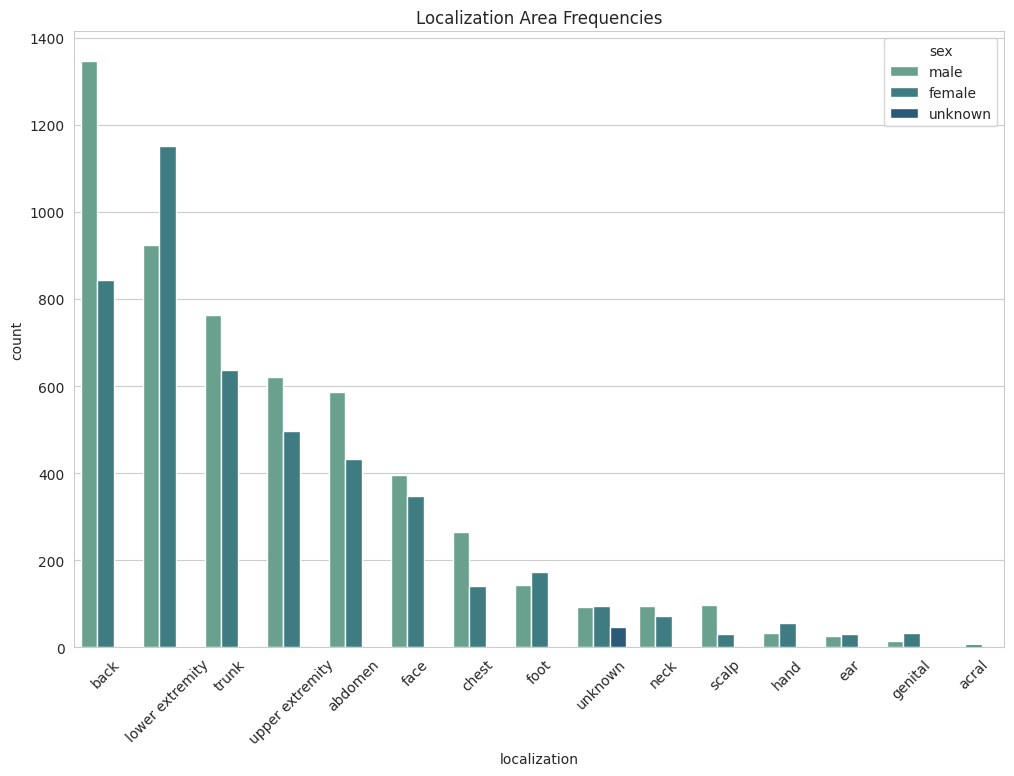

In [155]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'localization', hue = 'sex', data = df, order = df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

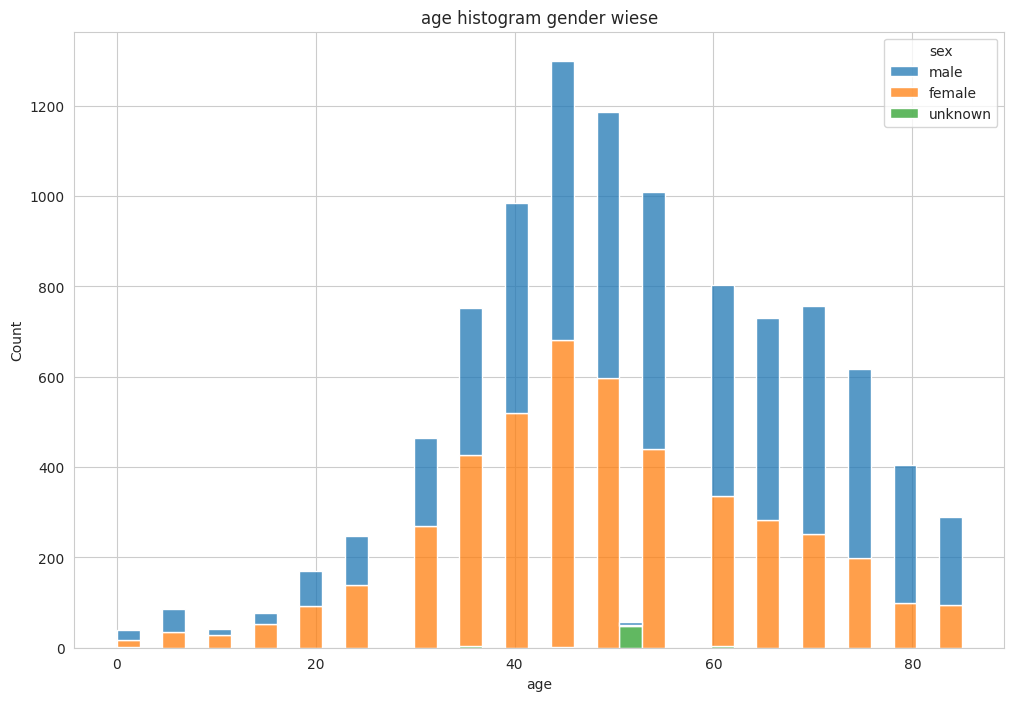

In [156]:

sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x = 'age', hue = 'sex', multiple='stack')
plt.title('age histogram gender wiese')
plt.show()

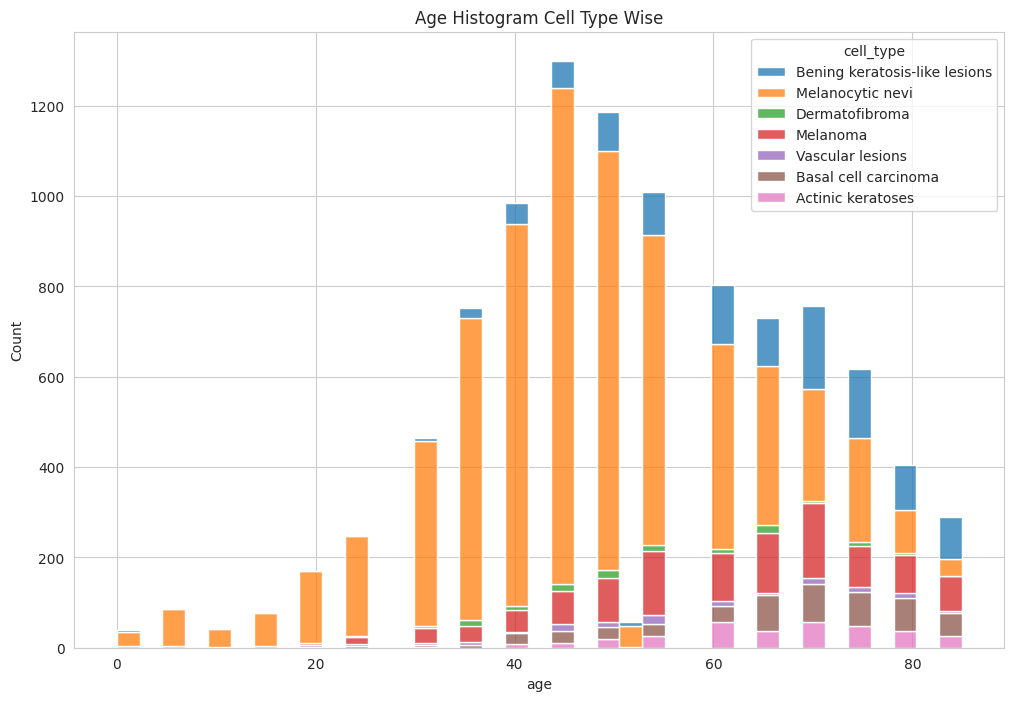

In [157]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

In [158]:
df["cell_type_idx"].value_counts()

cell_type_idx
4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64

## Image Segmentation

In [159]:
import cv2

In [160]:
# Function to read and resize images
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [161]:
image_size = (64, 64)

In [162]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

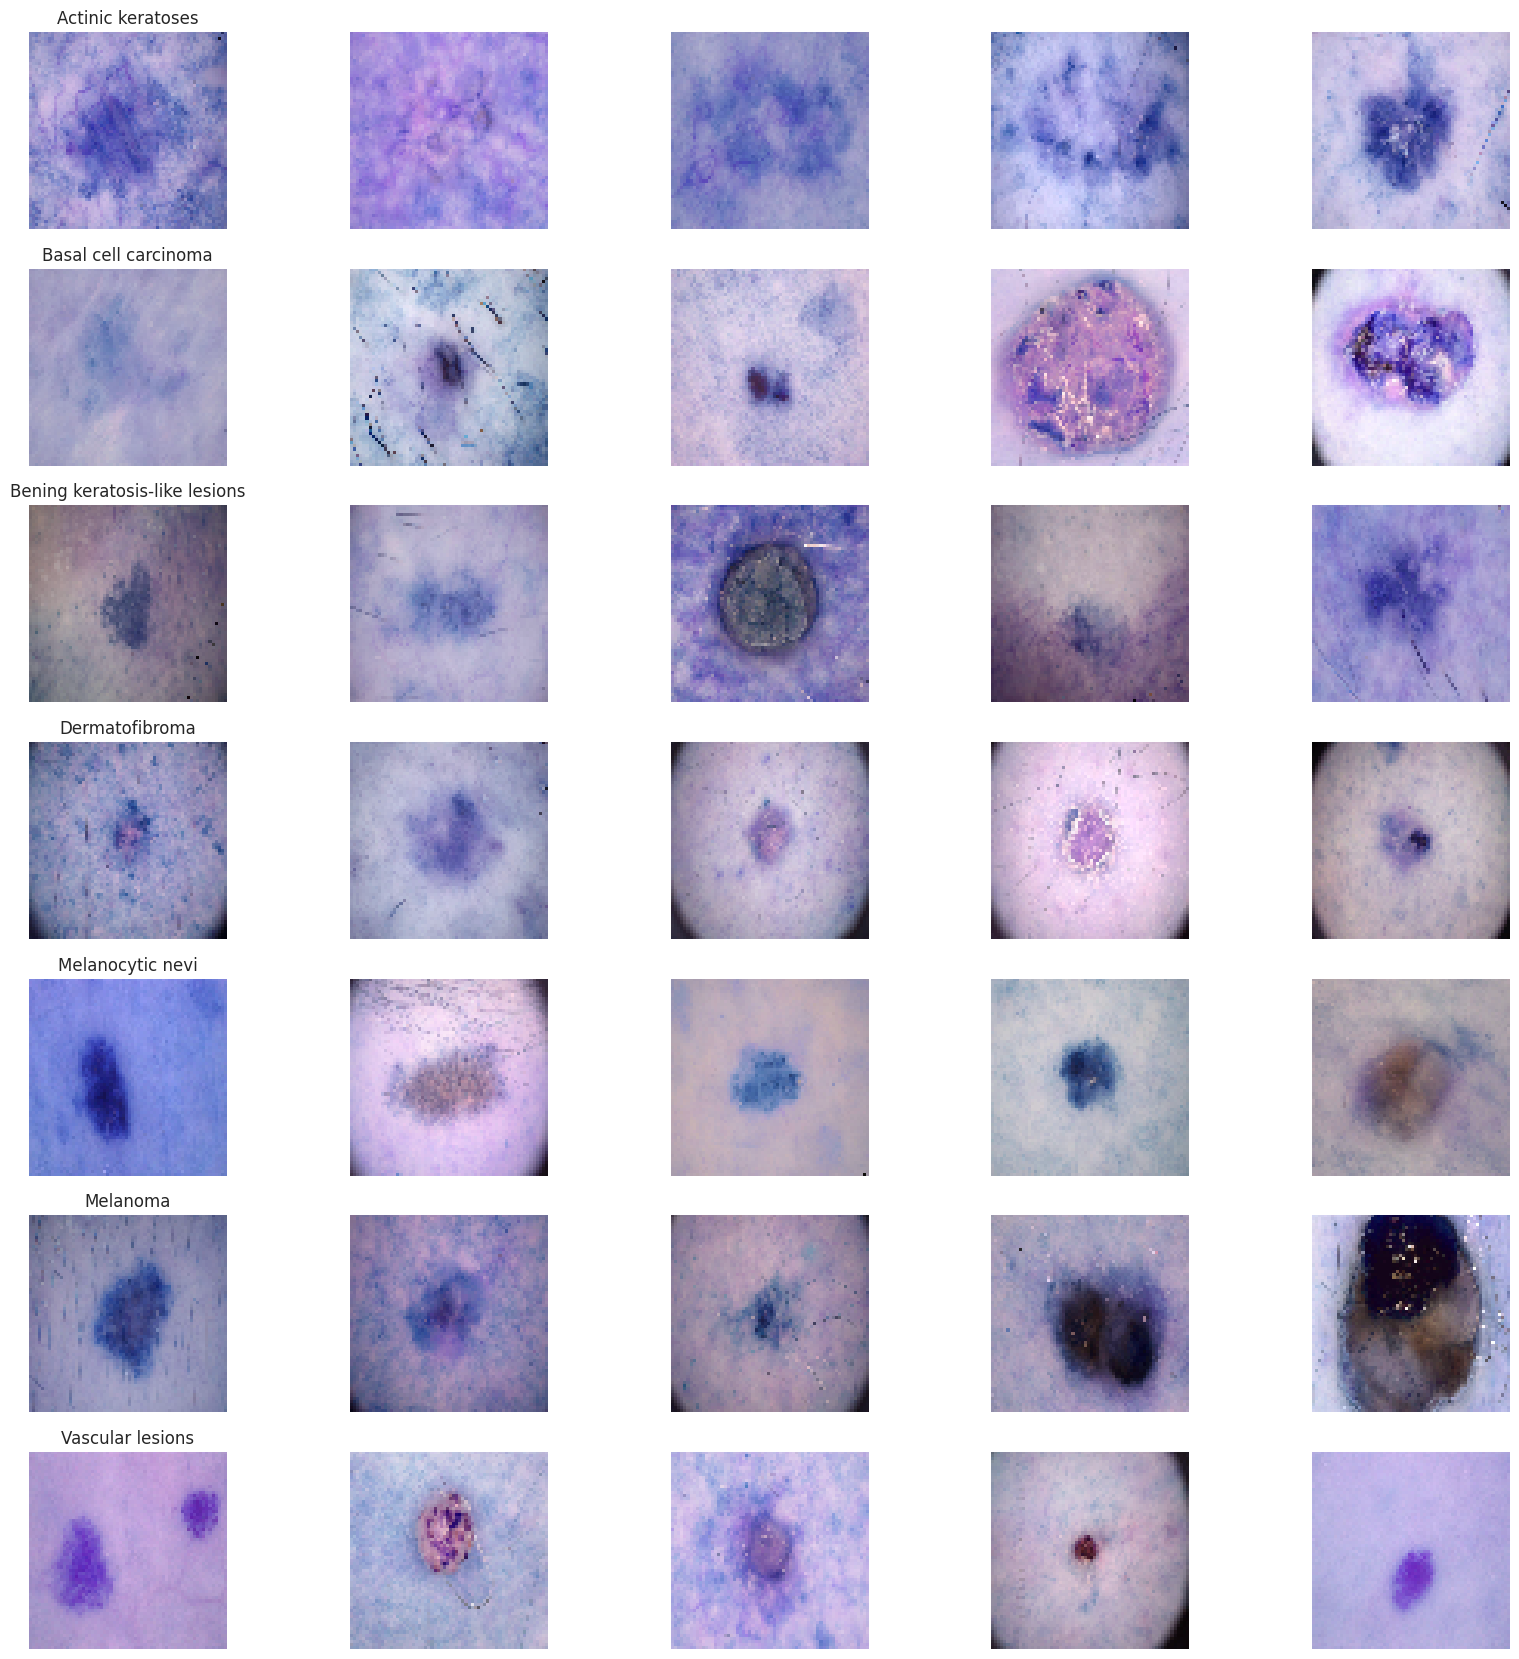

In [163]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [181]:
import skimage.io 
import skimage.segmentation

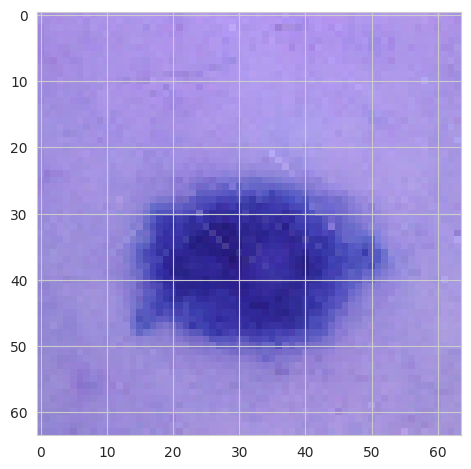

In [186]:
skimage.io.imshow(Xi)

The number of super pixels generated


6

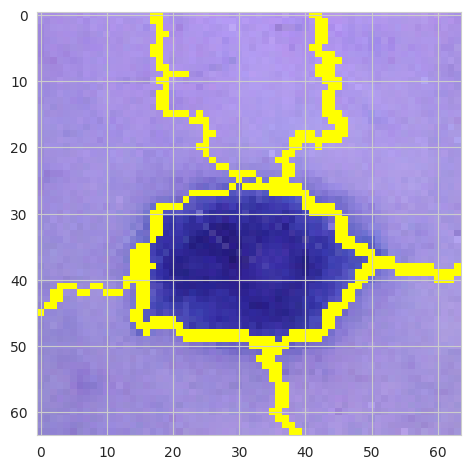

In [187]:
#Generate segmentation for image
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))
print("The number of super pixels generated")
num_superpixels

## Spliting the Data into Train and Test

In [164]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [165]:
# Extract the image data and target labels for train and test sets
X_train = np.stack(train_df['image'].values)
Y_train = train_df['cell_type_idx'].values
X_test = np.stack(test_df['image'].values)
Y_test = test_df['cell_type_idx'].values

In [166]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(8012, 64, 64, 3)
(8012,)
(2003, 64, 64, 3)
(2003,)


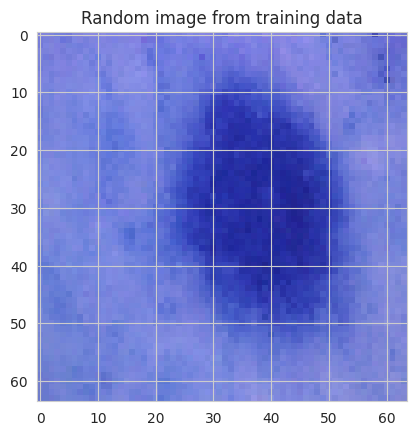

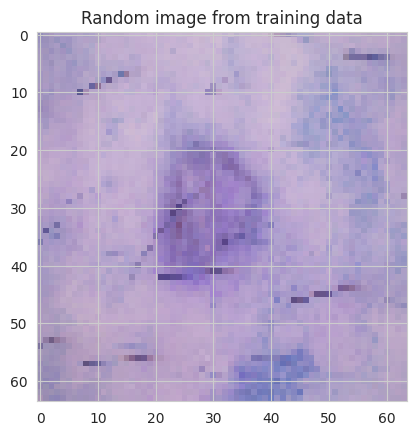

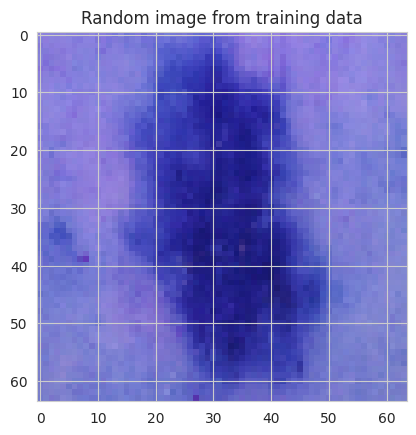

In [167]:
import matplotlib.pyplot as plt
import random
num=random.randint(0,8000)
X_train=np.array(X_train, dtype=np.uint8).reshape(-1,64,64,3)

plt.imshow(X_train[num].reshape(64,64,3))
plt.title("Random image from training data")
plt.show()
num=random.randint(0,8000)
plt.imshow(X_train[num].reshape(64,64,3))
plt.title("Random image from training data")
plt.show()

num=random.randint(0,8000)
plt.imshow(X_train[num].reshape(64,64,3))
plt.title("Random image from training data")
plt.show()

# Building Machine Learning Models

##### The CNN model is a repeated network of the following layers:
Convolutional

Pooling

Dropout

Flatten

Dense

Optimizer: Adam

Activation function used: Softmax

In [168]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))

In [169]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

## Model Training

In [170]:
model.fit(X_train, Y_train, batch_size=32, epochs=25, validation_split=0.1)

Epoch 1/25
226/226 [==============================] - 20s 85ms/step - loss: 5.2939 - accuracy: 0.6492 - val_loss: 0.9269 - val_accuracy: 0.6933
Epoch 2/25
226/226 [==============================] - 19s 84ms/step - loss: 0.9120 - accuracy: 0.6895 - val_loss: 0.8646 - val_accuracy: 0.7095
Epoch 3/25
226/226 [==============================] - 19s 84ms/step - loss: 0.8491 - accuracy: 0.7010 - val_loss: 0.8565 - val_accuracy: 0.7145
Epoch 4/25
226/226 [==============================] - 19s 84ms/step - loss: 0.7803 - accuracy: 0.7187 - val_loss: 0.8498 - val_accuracy: 0.7107
Epoch 5/25
226/226 [==============================] - 19s 84ms/step - loss: 0.7461 - accuracy: 0.7298 - val_loss: 0.8146 - val_accuracy: 0.7244
Epoch 6/25
226/226 [==============================] - 19s 83ms/step - loss: 0.7272 - accuracy: 0.7381 - val_loss: 0.8466 - val_accuracy: 0.7170
Epoch 7/25
226/226 [==============================] - 19s 83ms/step - loss: 0.6705 - accuracy: 0.7583 - val_loss: 0.8432 - val_accuracy:

In [171]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the accuracy
accuracy = np.mean(y_pred_classes == Y_test) * 100
print(f'Test accuracy: {accuracy:.2f}%')

63/63 [==============================] - 2s 23ms/step
Test accuracy: 67.50%


In [172]:
# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [173]:
import joblib

In [174]:
joblib.dump(model, 'cnn_model_skin.joblib')

['cnn_model_skin.joblib']

In [175]:
from sklearn.ensemble import RandomForestClassifier

In [176]:
loaded_cnn_model = joblib.load('cnn_model_skin.joblib')

In [177]:
X_train_features = loaded_cnn_model.predict(X_train)
X_test_features = loaded_cnn_model.predict(X_test)

63/63 [==============================] - 1s 23ms/step


In [178]:
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

## Model Evaluation

In [179]:
#All the models
def models(X_train_features_flat,Y_train):
  
  #Using Logistic Regression Algorithm to the Training Set
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_train_features_flat, Y_train)
  
  #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
  knn.fit(X_train_features_flat, Y_train)

  #Using SVC method of svm class to use Support Vector Machine Algorithm
  from sklearn.svm import SVC
  svc_lin = SVC(kernel = 'linear', random_state =0)
  svc_lin.fit(X_train_features_flat, Y_train)

  #Using SVC method of svm class to use Kernel SVM Algorithm
  from sklearn.svm import SVC
  svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  svc_rbf.fit(X_train_features_flat, Y_train)
 #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
  from sklearn.naive_bayes import GaussianNB
  gauss = GaussianNB()
  gauss.fit(X_train_features_flat, Y_train)

  #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
  from sklearn.tree import DecisionTreeClassifier
  tree =DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train_features_flat, Y_train)

  #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 10)
  forest.fit(X_train_features_flat, Y_train)
    
  #Using xgboostr method of ensemble class to use xgboostClassification algorithm
  import xgboost as xgb
  x_gb= xgb.XGBClassifier(objective="binary:logistic", n_estimators=20, random_state=42, eval_metric=["auc", "error", "error@0.6"])
  x_gb.fit(X_train_features_flat, Y_train)


  
    
  #print model accuracy on the training data.
  print('[0]Logistic Regression Training Accuracy:', log.score(X_train_features_flat, Y_train))
  print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train_features_flat, Y_train))
  print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train_features_flat, Y_train))
  print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train_features_flat, Y_train))
  print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train_features_flat, Y_train))
  print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train_features_flat, Y_train))
  print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train_features_flat, Y_train))
  print('[7]xgboost Classifier Training Accuracy:', x_gb.score(X_train_features_flat, Y_train))
  return log, knn, svc_lin, svc_rbf, gauss, tree, forest ,x_gb
model = models(X_train_features_flat,Y_train)

[0]Logistic Regression Training Accuracy: 0.9267348976535197
[1]K Nearest Neighbor Training Accuracy: 0.9343484772840739
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.927608587119321
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.9289815277084373
[4]Gaussian Naive Bayes Training Accuracy: 0.9169995007488767
[5]Decision Tree Classifier Training Accuracy: 0.9995007488766849
[6]Random Forest Classifier Training Accuracy: 0.9933849226160759
[7]xgboost Classifier Training Accuracy: 0.969171243135297


# Result

In [180]:
#Show other ways to get the classification accuracy & other metrics 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#from sklearn.metrics import plot_roc_curve
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import numpy as np
for i in range(len(model)):
  print('Model ',i)
  #Check Accuracy precision, recall, f1-score
  print( classification_report(Y_test, model[i].predict(X_test_features_flat)) )
  #Another way to get the models accuracy on the test data
  print(F'Accuracy:',accuracy_score(Y_test, model[i].predict(X_test_features_flat)))
 # print(F'Precision:', precision_score(Y_test, model[i].predict(X_test_features_flat)))
 # print(F'Recall:', recall_score(Y_test, model[i].predict(X_test_features_flat)))
  #print(F'F1 Score:', f1_score(Y_test, model[i].predict(X_test_features_flat)))

  #Check Roc Auc Score
 # print( F'Roc Auc Score:',roc_auc_score(Y_test, model[i].predict(X_test_features_flat)) )
 # print( F'Balanced Accuracy Score:',balanced_accuracy_score(Y_test, model[i].predict(X_test_features_flat)) ) 
  print( F'Confusion Matrix:',confusion_matrix(Y_test, model[i].predict(X_test_features_flat)) )
  print()#Print a new line

Model  0
              precision    recall  f1-score   support

           0       0.20      0.22      0.21        65
           1       0.28      0.20      0.24       103
           2       0.33      0.27      0.30       220
           3       0.33      0.04      0.08        23
           4       0.80      0.89      0.84      1341
           5       0.36      0.28      0.32       223
           6       0.88      0.25      0.39        28

    accuracy                           0.68      2003
   macro avg       0.45      0.31      0.34      2003
weighted avg       0.65      0.68      0.66      2003

Accuracy: 0.6764852720918622
Confusion Matrix: [[  14    3   23    0   17    8    0]
 [  19   21   22    1   32    8    0]
 [  13   18   60    0  106   23    0]
 [   3    1    7    1   10    1    0]
 [  14   20   48    1 1189   68    1]
 [   7    7   23    0  123   63    0]
 [   1    5    1    0   12    2    7]]

Model  1
              precision    recall  f1-score   support

           0   